# Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures

# Set global random seed for numpy and sklearn for reproducibility.
np.random.seed(42)

# Functions

In [2]:
# Transform dates
def date_handler(date):
    return date - 1974

#Defining several evaluation functions for convenience
def wmape_calc(y, predictions):
    soma = 0

    for e, i in zip(y, predictions):
        if e < 1e-2:
            soma += abs(e-i)
        else:
            soma += abs(e - i) / abs(e)
    
    return soma

def evaluation(y, predictions):
    mae = mean_absolute_error(y, predictions)
    mse = mean_squared_error(y, predictions)
    rmse = np.sqrt(mean_squared_error(y, predictions))
    r_squared = r2_score(y, predictions)
    mape = mean_absolute_percentage_error(y, predictions, sample_weight=y)
    wmape = wmape_calc(y, predictions)
    return mae, mse, rmse, r_squared, mape, wmape

# Loading Data

In [3]:
data = pd.read_csv("temporary_database.csv", index_col=0)

# Verify that the data is loaded correctly
print(data.columns)

data.head()

Index(['year', 'city_code', 'product_type', 'product', 'destinated_area'], dtype='object')


,year,city_code,product_type,product,destinated_area
0,1974-01-01,960b4f2c94a2fb2c,temporary,Others,0.0
1,1974-01-01,746cc42bfb8f6b62,temporary,Others,0.0
2,1974-01-01,6cce2bf873870afc,temporary,Others,0.0
3,1974-01-01,4de42e351006a2ae,temporary,Others,0.0
4,1974-01-01,5b6072f8f6d37acc,temporary,Others,0.0


In [4]:
print(data.product_type.value_counts())
print('\n')
print(data['product'].value_counts())

temporary    43824
Name: product_type, dtype: int64


Others     6292
Rice       6292
Beans      6292
Cassava    6292
Corn       6292
Sorghum    6204
Soy        6160
Name: product, dtype: int64


In [5]:
print(f"Number of NaN values in destinated_area column: {data.destinated_area.isna().sum()}\n")

data.info()

Number of NaN values in destinated_area column: 22772

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43824 entries, 0 to 43823
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   year             43824 non-null  object 
 1   city_code        43824 non-null  object 
 2   product_type     43824 non-null  object 
 3   product          43824 non-null  object 
 4   destinated_area  21052 non-null  float64
dtypes: float64(1), object(4)
memory usage: 2.0+ MB


As we can see above there is a significant amount of NaN values in the destinated area field, the way we are going to treat this values is replacing them by 0, assuming that in the cities that don't exist this values is because there isn't the plantation there, e.g., area 0.

And the only numeric variable present in this dataset It's the destinated area, which is our target. But, we need to add more numeric variables in our dataset with the goal of predict the target.

The way we are going to do this is by encoding the year column in a sequencial way and getting the one hot encoding of the cities.

It will generate features that will feed our ML model to predict the desired years.

# Pre Processing Data

In [33]:
# convert year column to datetime
permanent_data = data.copy()

permanent_data['year'] = pd.to_datetime(permanent_data['year'], format='%Y-%m-%d')

permanent_data['ano'] = permanent_data['year'].apply(lambda x: x.year)

permanent_data['ano'] = permanent_data['ano'].apply(lambda x: date_handler(x))

# Fill NaN values with 0 in destinated_area column
permanent_data['destinated_area'] = permanent_data['destinated_area'].fillna(0)

permanent_data.sort_values(by='ano').head()

,year,city_code,product_type,product,destinated_area,ano
0,1974-01-01,960b4f2c94a2fb2c,temporary,Others,0.0,0
6855,1974-01-01,b4bb04d2a6472ea0,temporary,Beans,0.0,0
6856,1974-01-01,b4bb04d2a6472ea0,temporary,Cassava,0.0,0
6857,1974-01-01,b4bb04d2a6472ea0,temporary,Corn,0.0,0
6858,1974-01-01,b4bb04d2a6472ea0,temporary,Soy,0.0,0


In [34]:
# Convert cities column to categorical using pandas get_dummies (One Hot Encoding)
permanent_data = pd.get_dummies(permanent_data, columns=['city_code', 'product'])

permanent_data.head()

,year,product_type,destinated_area,ano,city_code_0307883b5d063703,city_code_03e477d4ede00e89,city_code_051e9cc7d7636816,city_code_062ce4c17e84291e,city_code_074590cfc1c41ebf,city_code_07bba1a59af78f2d,...,city_code_fa005e1ffef6032a,city_code_fae378a53734da72,city_code_fda49275fbf5caf6,product_Beans,product_Cassava,product_Corn,product_Others,product_Rice,product_Sorghum,product_Soy
0,1974-01-01,temporary,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,1974-01-01,temporary,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,1974-01-01,temporary,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,1974-01-01,temporary,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,1974-01-01,temporary,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


# X, y Split

In [35]:
# Splitting the data into X and y chunks
X = permanent_data.drop("destinated_area", axis=1)
y = permanent_data["destinated_area"]

# Standardizing the Data

In [36]:
cat_cols = X.select_dtypes(include=['object']).columns
num_cols = X.select_dtypes(include=['float64', 'int64']).columns

scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

X.head()

,year,product_type,ano,city_code_0307883b5d063703,city_code_03e477d4ede00e89,city_code_051e9cc7d7636816,city_code_062ce4c17e84291e,city_code_074590cfc1c41ebf,city_code_07bba1a59af78f2d,city_code_07ce2e79e19977e9,...,city_code_fa005e1ffef6032a,city_code_fae378a53734da72,city_code_fda49275fbf5caf6,product_Beans,product_Cassava,product_Corn,product_Others,product_Rice,product_Sorghum,product_Soy
0,1974-01-01,temporary,-1.693123,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,1974-01-01,temporary,-1.693123,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,1974-01-01,temporary,-1.693123,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,1974-01-01,temporary,-1.693123,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,1974-01-01,temporary,-1.693123,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


# Train-Test Split

In [37]:
X_train = X[X['year'] < '2016-01-01']
X_test = X[X['year'] >= '2016-01-01']

y_train = y[X['year'] < '2016-01-01']
y_test = y[X['year'] >= '2016-01-01']

X_train = X_train.drop('year', axis=1)
X_train = X_train.drop(cat_cols, axis=1)
X_test = X_test.drop('year', axis=1)
X_test = X_test.drop(cat_cols, axis=1)

# Machine Learning Models

In [38]:
models = pd.DataFrame(columns=["Model","MAE","MSE","RMSE","R2 Score","MAPE","WMAPE"])

# Linear Regression

In [39]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
predictions = lin_reg.predict(X_test)

mae, mse, rmse, r_squared, mape, wmape= evaluation(y_test, predictions)
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r_squared)
print("MAPE:", mape)
print("WMAPE:", wmape)
print("-"*30)

new_row = {"Model": "LinearRegression","MAE": mae, "MSE": mse, "RMSE": rmse, "R2 Score": r_squared,  "MAPE": mape,"WMAPE": wmape}
models = models.append(new_row, ignore_index=True)

MAE: 1609.2444779116465
MSE: 30863611.455321286
RMSE: 5555.502808506291
R2 Score: 0.06410325772300696
MAPE: 1.1397168390542678
WMAPE: 654603.5895585095
------------------------------


# Ridge Regression

In [13]:
ridge = Ridge()
ridge.fit(X_train, y_train)
predictions = ridge.predict(X_test)

mae, mse, rmse, r_squared, mape, wmape= evaluation(y_test, predictions)
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r_squared)
print("MAPE:", mape)
print("WMAPE:", wmape)
print("-"*30)

new_row = {"Model": "Ridge","MAE": mae, "MSE": mse, "RMSE": rmse, "R2 Score": r_squared,  "MAPE": mape,"WMAPE": wmape}
models = models.append(new_row, ignore_index=True)

MAE: 1611.5966803864462
MSE: 30869100.504492242
RMSE: 5555.9968056589305
R2 Score: 0.06393680982546479
MAPE: 1.1410250807421942
WMAPE: 656457.3416424538
------------------------------


# Lasso Regression

In [14]:
lasso = Lasso()
lasso.fit(X_train, y_train)
predictions = lasso.predict(X_test)

mae, mse, rmse, r_squared, mape, wmape= evaluation(y_test, predictions)
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r_squared)
print("MAPE:", mape)
print("WMAPE:", wmape)
print("-"*30)

new_row = {"Model": "Lasso","MAE": mae, "MSE": mse, "RMSE": rmse, "R2 Score": r_squared,  "MAPE": mape,"WMAPE": wmape}
models = models.append(new_row, ignore_index=True)

MAE: 1630.9434471633883
MSE: 31001072.573160455
RMSE: 5567.860681910104
R2 Score: 0.05993493761044755
MAPE: 1.1444926027170248
WMAPE: 688353.964045217
------------------------------


# Elastic Net

In [15]:
elastic_net = ElasticNet()
elastic_net.fit(X_train, y_train)
predictions = elastic_net.predict(X_test)

mae, mse, rmse, r_squared, mape, wmape= evaluation(y_test, predictions)
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r_squared)
print("MAPE:", mape)
print("WMAPE:", wmape)
print("-"*30)

new_row = {"Model": "ElasticNet","MAE": mae, "MSE": mse, "RMSE": rmse, "R2 Score": r_squared,  "MAPE": mape,"WMAPE": wmape}
models = models.append(new_row, ignore_index=True)

MAE: 1637.6247549076088
MSE: 32876222.272675734
RMSE: 5733.779056841634
R2 Score: 0.003073591439131107
MAPE: 1.1059036499606336
WMAPE: 789586.4132121176
------------------------------


# Support Vector Machines

In [ ]:
svr = SVR(C=100000)
svr.fit(X_train, y_train)
predictions = svr.predict(X_test)

mae, mse, rmse, r_squared, mape, wmape= evaluation(y_test, predictions)
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r_squared)
print("MAPE:", mape)
print("WMAPE:", wmape)
print("-"*30)

new_row = {"Model": "SVR","MAE": mae, "MSE": mse, "RMSE": rmse, "R2 Score": r_squared,  "MAPE": mape,"WMAPE": wmape}
models = models.append(new_row, ignore_index=True)

# Random Forest Regressor

In [40]:
random_forest = RandomForestRegressor(n_estimators=100, n_jobs=-1)
random_forest.fit(X_train, y_train)
predictions = random_forest.predict(X_test)

mae, mse, rmse, r_squared, mape, wmape= evaluation(y_test, predictions)
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r_squared)
print("MAPE:", mape)
print("WMAPE:", wmape)
print("-"*30)

new_row = {"Model": "RandomForestRegressor","MAE": mae, "MSE": mse, "RMSE": rmse, "R2 Score": r_squared,  "MAPE": mape,"WMAPE": wmape}
models = models.append(new_row, ignore_index=True)

MAE: 474.65111445783134
MSE: 5682926.906614458
RMSE: 2383.889029844816
R2 Score: 0.8276730256859899
MAPE: 0.392801908898542
WMAPE: 58813.19333197107
------------------------------


# XGBoost Regressor

In [17]:
xgb = XGBRegressor(n_estimators=1000, learning_rate=0.01)
xgb.fit(X_train, y_train)
predictions = xgb.predict(X_test)

mae, mse, rmse, r_squared, mape, wmape= evaluation(y_test, predictions)
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r_squared)
print("MAPE:", mape)
print("WMAPE:", wmape)
print("-"*30)

new_row = {"Model": "XGBRegressor","MAE": mae, "MSE": mse, "RMSE": rmse, "R2 Score": r_squared,  "MAPE": mape,"WMAPE": wmape}
models = models.append(new_row, ignore_index=True)

MAE: 923.3516808428678
MSE: 10961274.969623726
RMSE: 3310.7816251791246
R2 Score: 0.6676143506367116
MAPE: 0.7122827910853881
WMAPE: 240973.7328938988
------------------------------


# Polynomial Regression (Degree=2)

In [23]:
poly_reg = PolynomialFeatures(degree=2)
X_train_2d = poly_reg.fit_transform(X_train)
X_test_2d = poly_reg.transform(X_test)

lin_reg = LinearRegression()
lin_reg.fit(X_train_2d, y_train)
predictions = lin_reg.predict(X_test_2d)

mae, mse, rmse, r_squared, mape, wmape= evaluation(y_test, predictions)
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r_squared)
print("MAPE:", mape)
print("WMAPE:", wmape)
print("-"*30)

new_row = {"Model": "PolynomialFeatures","MAE": mae, "MSE": mse, "RMSE": rmse, "R2 Score": r_squared,  "MAPE": mape,"WMAPE": wmape}
models = models.append(new_row, ignore_index=True)

MemoryError: Unable to allocate 3.62 GiB for an array with shape (41832, 11628) and data type float64

# Model Comparison

In [21]:
#The less the Root Mean Squared Error (R2), The better the model is.
models.sort_values(by="R2 Score")

,Model,MAE,MSE,RMSE,R2 Score,MAPE,WMAPE
3,ElasticNet,1637.624755,3.287622e+07,5733.779057,0.003074,1.105904,789586.413212
2,Lasso,1630.943447,3.100107e+07,5567.860682,0.059935,1.144493,688353.964045
1,Ridge,1611.596680,3.086910e+07,5555.996806,0.063937,1.141025,656457.341642
0,LinearRegression,1609.244478,3.086361e+07,5555.502809,0.064103,1.139717,654603.589559
5,XGBRegressor,923.351681,1.096127e+07,3310.781625,0.667614,0.712283,240973.732894
4,RandomForestRegressor,478.013524,5.904653e+06,2429.949162,0.820949,0.399608,50312.270674


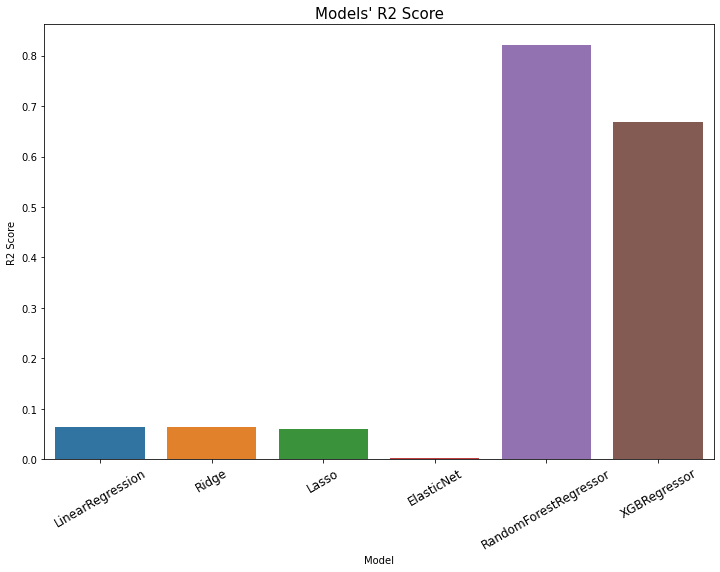

In [22]:
plt.figure(figsize=(12,8))
sns.barplot(x=models["Model"], y=models["R2 Score"])
plt.title("Models' R2 Score", size=15)
plt.xticks(rotation=30, size=12)
plt.show()